In [1]:
# %load Avi_Sklearn.py
#!/usr/bin/env python

# In[11]:

from tqdm import tqdm
import numpy as np
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPRegressor    #### MLP 感知机####
from sklearn.tree import ExtraTreeRegressor        #### ExtraTree极端随机树回归####
from sklearn import tree                           #### 决策树回归####
from sklearn.ensemble import BaggingRegressor      #### Bagging回归####
from sklearn.ensemble import AdaBoostRegressor     #### Adaboost回归
from sklearn import linear_model                   #### 线性回归####
from sklearn import svm                            #### SVM回归####
from sklearn import ensemble                       #### Adaboost回归####  ####3.7GBRT回归####  ####3.5随机森林回归####
from sklearn import neighbors                      #### KNN回归####
from sklearn.preprocessing import StandardScaler
import os
import xgboost as xg
import pandas as pd
from evaluate_data import *
import openpyxl
import warnings
warnings.filterwarnings("ignore")
datalist = []
# %load sklearn.py
# @Time    : 2021/7/16 0016 19:55
# @Author  : pimaozheng
# @Site    : 
# @File    : 机器学习方法.py
# @Software: PyCharm

# def nmindata(dataset,n):
#     df = dataset[['timeStamp','ghi']]
#     df['timeStamp'] = pd.to_datetime(df['timeStamp'])
#     df.set_index('timeStamp', inplace=True)
#     df.resample('30T').mean()


def create_data(data, train_num, ahead_num):
    train_num = round(0.8*len(data))
    
    dataX1, dataX2 = [], []
    dataY1, dataY2 = [], []

    for i in range(train_num - ahead_num):
        # print(i)
        a = data[i:(i + ahead_num), 0]
        dataX1.append(a)
    for j in range(train_num - ahead_num, len(data) - ahead_num):
        b = data[j:(j + ahead_num), 0]
        dataX2.append(b)

    dataY1 = data[ahead_num:train_num, 0]
    dataY2 = data[train_num:, 0]
    return np.array(dataX1), np.array(dataY1), np.array(dataX2), np.array(dataY2)
#评价指标
def smape(y_true, y_pred):
    L1 = int(len(y_true))
    L2 = int(len(y_pred))
    # print(L1,L2)
    if L1 == L2:
        # SUM1=sum(abs(true-predict)/abs(true))
        SUM = 0.0
        for i in range(L1):
            a= 2.0*(abs(y_true[i] - y_pred[i]))
            b=np.abs(y_pred[i]) + np.abs(y_true[i])
            SUM=a/b+SUM
        per_SUM = SUM * 100.0
        smape = per_SUM / L1
        return smape


    return 2.0 * np.mean(np.abs(y_pred[i] - y_true[i]) / (np.abs(y_pred[i]) + np.abs(y_true[i]))) * 100
##加载数据
def load_data(filename, ahead_num,n):
    dataset = pd.read_csv(filename,encoding='gbk')
    dataset = pd.DataFrame(dataset)
    dataPOV = dataset # [['timeStamp','ghi']]
#     dataPOV.dropna(inplace=True)
    
#     dataset = pd.read_csv(filename,encoding='gbk')
#     dataset = pd.DataFrame(dataset)
#     dataPOV = dataset['ghi']

    
    
    dataPOV['timeStamp'] = pd.to_datetime(dataPOV['timeStamp'])
    dataPOV.set_index('timeStamp', inplace=True)
    dataPOV = dataPOV.resample(f'{n}T').mean()
    dataPOV.dropna(inplace=True)
    
    ########## create data ####
    
    dataPOV = dataPOV[['air_temp','windsp','winddir','ghi']]
    
    DataMain = pd.concat([dataPOV,dataPOV.shift(-1),dataPOV.shift(-2),
                         dataPOV.shift(-3),dataPOV.shift(-4)],axis=1)
    
    DataMain['Target_ghi'] = dataPOV['ghi'].shift(-5)
    
    DataMain.dropna(inplace=True)
    ###########################
    
#     dataPOV = np.array(dataPOV).reshape(-1,1)
#     print("dataPOV:",dataPOV.shape)
    N1=70000
#     N2 = N1+10000
    dataAll = DataMain.iloc[:N1]
    
#     print('NAN:-->',np.argwhere(np.isnan(dataAll)))
    #归一化
#     global scaler
#     scaler = StandardScaler(copy=True,with_mean=True,with_std=True)
#     dataAll = scaler.fit_transform(dataAll)

    X = dataAll.drop('Target_ghi',axis=1).values
    y = dataAll['Target_ghi'].values
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
    
    from sklearn.preprocessing import MinMaxScaler
    sc_X = MinMaxScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.transform(X_test)
    
    

#     trainX, trainY, testX, testY = create_data(dataAll,N1,ahead_num)
#     print("trainX", trainX.shape)
#     print("trainY", trainY.shape)
    return X_train, y_train, X_test, y_test   #dataFll

def pre_model(model,trainX,trainY,testX):
    model.fit(trainX,trainY)
    predict = model.predict(testX)
    return predict.reshape(-1, 1)

def main():
    np.random.RandomState(7)
    global ahead_num
    ahead_num = 8
    # #多分钟
    filename =  "Folsom_irradiance.csv"
    df = pd.DataFrame([],columns=['Measure','DT','LR','SVR','KNN','BAG','RF','ADA','GB','XGBOOST'])
    
    for n in tqdm([1,5,10,15,30]):
        x_train, y_train, x_test, y_test = load_data(filename, ahead_num,n)
        y_train = y_train.reshape(-1,1)
        y_test = y_test.reshape(-1,1)

        print("x_train:",x_train.shape)
        print("y_train:", y_train.shape)
        print("x_test:", x_test.shape)
        print("y_test:", y_test.shape)

    
        ##====================多模型  multi single model
        model_DecisionTreeRegressor = tree.DecisionTreeRegressor()     #决策树
        model_RandomForestRegressor = ensemble.RandomForestRegressor(n_estimators=50)  # 随机森林
        model_GradientBoostingRegressor = ensemble.GradientBoostingRegressor(n_estimators=50)  # GDBT
        model_LinearRegression = linear_model.LinearRegression()  # 线性回归
        model_SVR = svm.SVR()                                        # SVR回归
        model_KNeighborsRegressor = neighbors.KNeighborsRegressor()  # KNN回归
        model_ExtraTreeRegressor = ExtraTreeRegressor()  # extra tree
        model_MLP = MLPRegressor(solver='lbfgs', hidden_layer_sizes=(20, 20, 20), random_state=2)  # MLP
        model_BaggingRegressor = BaggingRegressor()   # bggingRegressor
        model_AdaboostRegressor = AdaBoostRegressor() # adaboostRegressor
        model_xgb = xg.XGBRegressor()
        
        ##预测=============predict
        predict_decideTree = pre_model(model_DecisionTreeRegressor,x_train, y_train, x_test)
        print('decideTree completed')
        predict_randomForest = pre_model(model_RandomForestRegressor,x_train, y_train, x_test)
        print('randomForest completed')
        predict_linear = pre_model(model_LinearRegression, x_train, y_train, x_test)
        print('predict_linear completed')
        predict_svr = pre_model(model_SVR, x_train, y_train, x_test)
        print('predict_svr completed')
        predict_kNeighbors = pre_model(model_KNeighborsRegressor, x_train, y_train, x_test)
        print('predict_kNeighbors completed')
        predict_gradientBoosting = pre_model(model_GradientBoostingRegressor, x_train, y_train, x_test)
        print('predict_gradientBoosting completed')
        predict_extraTree = pre_model(model_ExtraTreeRegressor, x_train, y_train, x_test)
        print('predict_extraTree completed')
        predict_mlp = pre_model(model_MLP, x_train, y_train, x_test)

        print('predict_mlp completed')

        predict_bagging = pre_model(model_BaggingRegressor, x_train, y_train, x_test)

        print('predict_bagging completd')
        predict_adaboost = pre_model(model_AdaboostRegressor,x_train,y_train,x_test)
    
        # xgboost
        predict_xgboost = pre_model(model_xgb,x_train,y_train,x_test)

        print('predict_adaboost and xgboost completd')
        ##===============反归一化
#         global scaler
# #         print('predict_decideTree')
# #         print(predict_decideTree)
#         predict_decideTree = scaler.inverse_transform(predict_decideTree)
#         predict_randomForest = scaler.inverse_transform(predict_randomForest)
#         predict_linear = scaler.inverse_transform(predict_linear)
#         predict_svr = scaler.inverse_transform(predict_svr)
#         predict_kNeighbors = scaler.inverse_transform(predict_kNeighbors)
#         predict_gradientBoosting = scaler.inverse_transform(predict_gradientBoosting)
#         predict_extraTree = scaler.inverse_transform(predict_extraTree)
#         predict_mlp = scaler.inverse_transform(predict_mlp)
#         predict_bagging = scaler.inverse_transform(predict_bagging)
#         predict_adaboost = scaler.inverse_transform(predict_adaboost)

#         dataY = scaler.inverse_transform(y_test)

        dataY = y_test

        mae_decideTree = MAE1(dataY,predict_decideTree)
        rmse_decideTree = RMSE1(dataY,predict_decideTree)
        mape_decideTree = MAPE1(dataY,predict_decideTree)
        r2_decideTree = r2_score(dataY, predict_decideTree)
        sampe_decideTree=smape(dataY, predict_decideTree)


#         print(f"======================= {n} min Result ===============================")
#         print("rmse_decideTree:",rmse_decideTree)
#         print("mape_decideTree:",mape_decideTree[0])
#         print("mae_decideTree:",mae_decideTree)
#         print("R_decideTree",r2_decideTree)
        
#         print('\n')
#         print("sampe_decideTree", sampe_decideTree)

       #  #=======================random forest
        rmse_randomForest = RMSE1(dataY,predict_randomForest)
        mape_randomForest = MAPE1(dataY,predict_randomForest)
        mae_randomForest = MAE1(dataY,predict_randomForest)
        r2_randomForest = r2_score(dataY, predict_randomForest)
        sampe_randomForest = smape(dataY, predict_randomForest)
    #     print("R2_randomForest", r2_randomForest)
        adjust_R = 1 - ((1 - r2_randomForest) * (1000 - 1)) / (1000 - 1 - 1)
    #     print("adjust_R", adjust_R)
    
        
#         print("rmse_randomForest:",rmse_randomForest)
#         print("mape_randomForest:",mape_randomForest[0])
#         print("mae_randomForest:", mae_randomForest)
#         print("r2_randomForest",r2_randomForest)
#         print('\n')
#         print("sampe_randomForest",sampe_randomForest)

        rmse_linear = RMSE1(dataY,predict_linear)
        mape_linear = MAPE1(dataY,predict_linear)
        mae_linear = MAE1(dataY,predict_linear)
        r2_linear = r2_score(dataY, predict_linear)
        smape_linear=smape(dataY, predict_linear)
        
#         print("R2_linear", r2_linear)
#         print("mae_linear:", mae_linear)
#         print("rmse_linear:", rmse_linear)
#         print("mape_linear:", mape_linear[0])
#         print('\n')
#         print("smape_linear",smape_linear)

        rmse_svr = RMSE1(dataY,predict_svr)
        mape_svr = MAPE1(dataY,predict_svr)
        mae_svr = MAE1(dataY,predict_svr)
        r2_svr = r2_score(dataY, predict_svr)
        smape_svr=smape(dataY, predict_svr)
        
#         print("R2_svr", r2_svr)
#         print("mae_svr:", mae_svr)
#         print("rmse_svr:", rmse_svr)
#         print("mape_svr:", mape_svr[0])
#         print('\n')
#         print("smape_svr",smape_svr)

        rmse_kNeighbors = RMSE1(dataY,predict_kNeighbors)
        mape_kNeighbors = MAPE1(dataY,predict_kNeighbors)
        mae_kNeighbors = MAE1(dataY,predict_kNeighbors)
        r2_kNeighbors = r2_score(dataY, predict_kNeighbors)
        smape_kNeighbors=smape(dataY, predict_kNeighbors)
        
#         print("R2_kNeighbors", r2_kNeighbors)
#         print("mae_kNeighbors:", mae_kNeighbors)
#         print("rmse_kNeighbors:", rmse_kNeighbors)
#         print("mape_kNeighbors:", mape_kNeighbors[0])
#         print('\n')
#         print("smape_kNeighbors",smape_kNeighbors)

        rmse_mlp = RMSE1(dataY,predict_mlp)
        mape_mlp = MAPE1(dataY,predict_mlp)
        mae_mlp = MAE1(dataY,predict_mlp)
        r2_mlp = r2_score(dataY, predict_mlp)
        sampe_mlp=smape(dataY, predict_mlp)
    #     print("R2_mlp", r2_mlp)
    #     print("mae_mlp:", mae_mlp)
    #     print("rmse_mlp:", rmse_mlp)
    #     print("mape_mlp:", mape_mlp)
    #     print("sampe_mlp",sampe_mlp)

        rmse_gradientBoosting = RMSE1(dataY,predict_gradientBoosting)
        mape_gradientBoosting = MAPE1(dataY,predict_gradientBoosting)
        mae_gradientBoosting = MAE1(dataY,predict_gradientBoosting)
        r2_gradientBoosting  = r2_score(dataY, predict_gradientBoosting)
        sampe_gradientBoosting=smape(dataY,predict_gradientBoosting)
        
#         print("R2_gradientBoosting ", r2_gradientBoosting )
#         print("mae_gradientBoosting:", mae_gradientBoosting)
#         print("rmse_gradientBoosting:", rmse_gradientBoosting)
#         print("mape_gradientBoosting:", mape_gradientBoosting[0])
#         print('\n')
#         print("sampe_gradientBoosting",sampe_gradientBoosting)

        rmse_extraTree = RMSE1(dataY,predict_extraTree)
        mape_extraTree = MAPE1(dataY,predict_extraTree)
        mae_extraTree = MAE1(dataY,predict_extraTree)
        r2_extraTree = r2_score(dataY, predict_extraTree)
        sampe_extraTree=smape(dataY, predict_extraTree)
        
    #     print("R2_extraTree ", r2_extraTree)
    #     print("mae_extraTree:", mae_extraTree)
    #     print("rmse_extraTree:", rmse_extraTree)
    #     print("mape_extraTree:", mape_extraTree)
    #     print("sampe_extraTree",sampe_extraTree)

        rmse_bagging = RMSE1(dataY,predict_bagging)
        mape_bagging = MAPE1(dataY,predict_bagging)
        mae_bagging = MAE1(dataY,predict_bagging)
        r2_bagging = r2_score(dataY, predict_bagging)
        smape_bagging=smape(dataY,predict_bagging)
        
#         print("R2_bagging ", r2_bagging)
#         print("mae_bagging:", mae_bagging)
#         print("rmse_bagging:", rmse_bagging)
#         print("mape_bagging:", mape_bagging[0])
#         print('\n')
#         print("smape_bagging",smape_bagging)

        rmse_adaboost = RMSE1(dataY,predict_adaboost)
        mape_adaboost = MAPE1(dataY,predict_adaboost)
        mae_adaboost = MAE1(dataY,predict_adaboost)
        r2_adaboost = r2_score(dataY, predict_adaboost)
        
        rmse_xgboost = RMSE1(dataY,predict_xgboost)
        mape_xgboost = MAPE1(dataY,predict_xgboost)
        mae_xgboost = MAE1(dataY,predict_xgboost)
        r2_xgboost = r2_score(dataY, predict_xgboost)
        
        
#         print("R2_adaboost ", r2_adaboost)
#         print("mae_adaboost:", mae_adaboost)
#         print("rmse_bagging:", rmse_adaboost)
#         print("mape_adaboost:", mape_adaboost[0])
#         print('\n')
        
        ################# Generate CSV file for Measure ###############
        
        df.loc[len(df)]= [n] + [float('nan')]*9 # '__'
        df.loc[len(df)] = ['RMSE'] + [rmse_xgboost,rmse_decideTree,rmse_linear,rmse_svr,rmse_kNeighbors,rmse_bagging,rmse_randomForest,rmse_adaboost,rmse_gradientBoosting]
        df.loc[len(df)] = ['MAPE'] + [mape_xgboost[0],mape_decideTree[0],mape_linear[0],mape_svr[0],mape_kNeighbors[0],mape_bagging[0],mape_randomForest[0],mape_adaboost[0],mape_gradientBoosting[0]]
        df.loc[len(df)] = ['MAE'] +  [mae_xgboost,mae_decideTree,mae_linear,mae_svr,mae_kNeighbors,mae_bagging,mae_randomForest,mae_adaboost,mae_gradientBoosting]
        df.loc[len(df)] = ['R2Square'] + [r2_xgboost,r2_decideTree,r2_linear,r2_svr,r2_kNeighbors,r2_bagging,r2_randomForest,r2_adaboost,r2_gradientBoosting]


    #     ###===============画图===========================
    
        datalist.append((dataY[:],predict_decideTree,predict_randomForest,predict_linear,predict_svr,predict_kNeighbors,predict_gradientBoosting,predict_bagging,predict_adaboost,predict_xgboost))
    df.to_csv('performance27FEB_withxgboost.csv')

if __name__=="__main__":

    main()


# In[ ]:



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

x_train: (56000, 20)
y_train: (56000, 1)
x_test: (14000, 20)
y_test: (14000, 1)
decideTree completed
randomForest completed
predict_linear completed
predict_svr completed
predict_kNeighbors completed
predict_gradientBoosting completed
predict_extraTree completed
predict_mlp completed
predict_bagging completd
predict_adaboost and xgboost completd


 20%|████████████████▌                                                                  | 1/5 [13:17<53:11, 797.92s/it]

x_train: (56000, 20)
y_train: (56000, 1)
x_test: (14000, 20)
y_test: (14000, 1)
decideTree completed
randomForest completed
predict_linear completed
predict_svr completed
predict_kNeighbors completed
predict_gradientBoosting completed
predict_extraTree completed
predict_mlp completed
predict_bagging completd
predict_adaboost and xgboost completd


 40%|█████████████████████████████████▏                                                 | 2/5 [21:33<35:21, 707.32s/it]

x_train: (43192, 20)
y_train: (43192, 1)
x_test: (10799, 20)
y_test: (10799, 1)
decideTree completed
randomForest completed
predict_linear completed
predict_svr completed
predict_kNeighbors completed
predict_gradientBoosting completed
predict_extraTree completed
predict_mlp completed
predict_bagging completd
predict_adaboost and xgboost completd


 60%|█████████████████████████████████████████████████▊                                 | 3/5 [28:17<20:32, 616.27s/it]

x_train: (29002, 20)
y_train: (29002, 1)
x_test: (7251, 20)
y_test: (7251, 1)
decideTree completed
randomForest completed
predict_linear completed
predict_svr completed
predict_kNeighbors completed
predict_gradientBoosting completed
predict_extraTree completed
predict_mlp completed
predict_bagging completd
predict_adaboost and xgboost completd


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [30:56<07:58, 478.90s/it]

x_train: (14792, 20)
y_train: (14792, 1)
x_test: (3698, 20)
y_test: (3698, 1)
decideTree completed
randomForest completed
predict_linear completed
predict_svr completed
predict_kNeighbors completed
predict_gradientBoosting completed
predict_extraTree completed
predict_mlp completed
predict_bagging completd
predict_adaboost and xgboost completd


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [31:51<00:00, 382.32s/it]


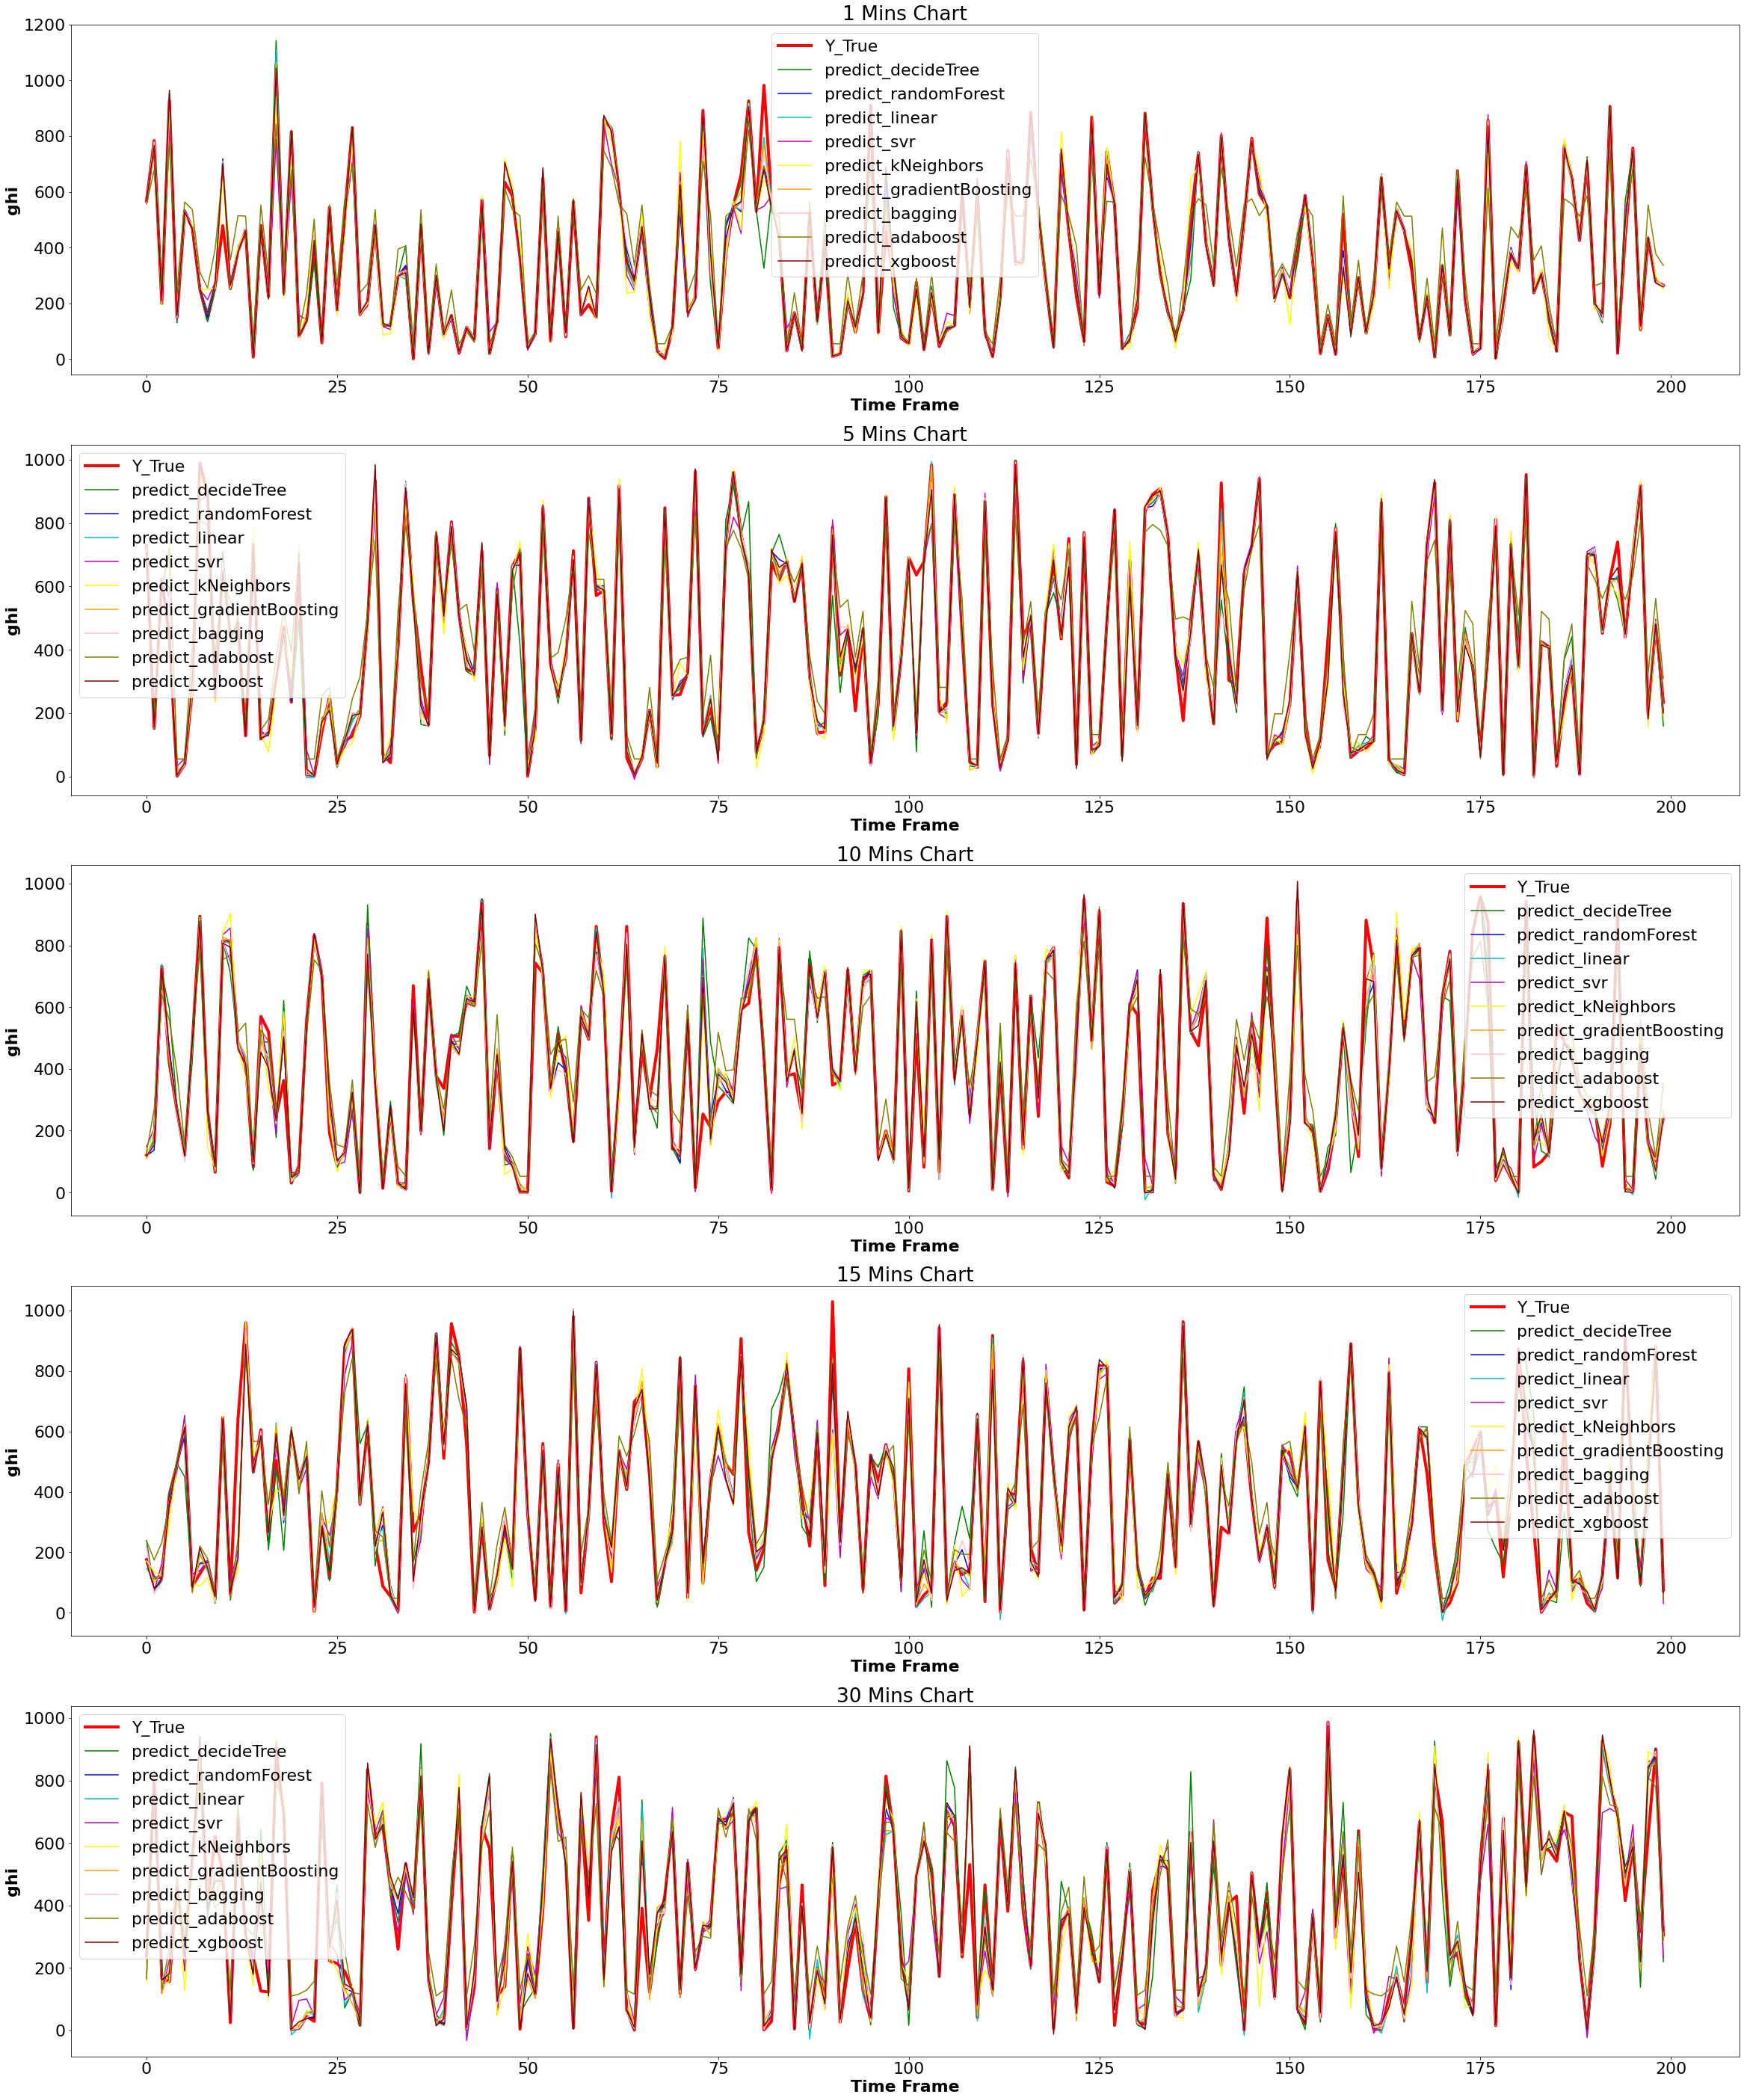

In [2]:
name = ['Y_True','predict_decideTree','predict_randomForest','predict_linear','predict_svr',
        'predict_kNeighbors','predict_gradientBoosting','predict_bagging','predict_adaboost','predict_xgboost']
n = [1,5,10,15,30]

color = ['r','g','b','c','m','yellow','orange','pink','olive','maroon']

plt.rcParams.update({'font.size': 22})

fig, ax = plt.subplots(5,figsize=(40,50),)

for i,mindata in enumerate(datalist) :
    for indx, data in enumerate(mindata):
        
        label = name[indx]
        mycolor = color[indx]
        if indx==0:
            ax[i].plot(data[:200],label=label,linestyle='solid',linewidth=4,color=mycolor)
        else:
            ax[i].plot(data[:200],label=label,color=mycolor)

        ax[i].title.set_text(str(n[i])+' Mins Chart')
        ax[i].set_xlabel('Time Frame',fontweight="bold",fontsize = 22)
        ax[i].set_ylabel('ghi',fontweight="bold",fontsize = 22)
        ax[i].legend()

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("Folsom_irradiance.csv")

In [3]:
df

,timeStamp,ghi,air_temp,windsp,winddir
0,2014/1/2 15:22,3.08,2.90,1.76,187.8
1,2014/1/2 15:23,3.08,2.90,1.90,197.8
2,2014/1/2 15:24,3.18,2.90,1.82,199.4
3,2014/1/2 15:25,3.80,2.90,2.22,197.2
4,2014/1/2 15:26,4.00,2.90,2.30,212.3
...,...,...,...,...,...
533474,2016/1/14 1:01,1.70,11.76,1.14,175.7
533475,2016/1/14 1:02,3.47,11.70,0.54,221.6
533476,2016/1/14 1:03,6.20,11.66,0.86,204.3
533477,2016/1/14 1:04,5.38,11.60,1.16,193.6
